In [1]:
using GoldGates
using MSSim: Optimizers as Opts, SegSeq as SS, SymLinear as SL, Sequence as Seq, Utils as U
using BenchmarkTools
using NLopt
using Statistics
using PyPlot
using JSON
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

"module://matplotlib_inline.backend_inline"

In [2]:
sysparams = open("../system params/072125_goldparams_13ions.json") do io
    read(io, GoldGates.SystemParams; format=:json)
end;

In [3]:
# Constants across notebook
const nions = 13

# Objective function for optimization
function _objfunc(vals)
    dis = vals[1]
    disδ = vals[2]
    area = vals[3]
    areaδ = vals[4]
    τ = vals[5]

    return 5 * dis + disδ / 100 + (abs(area) - π / 2)^2 * 100 + (areaδ / 1e4)^2
end
const objfunc = Opts.autodiff(_objfunc);
const modes = Seq.Modes()
const nions = 13
const ion1 = 5
const ion2 = 9
for i in 1:nions
    push!(modes, 2π * sysparams.modes.radial1[i], sysparams.participation_factors[i][ion1] * sysparams.participation_factors[i][ion2] * sysparams.lamb_dicke_parameters[i]^2)
end

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


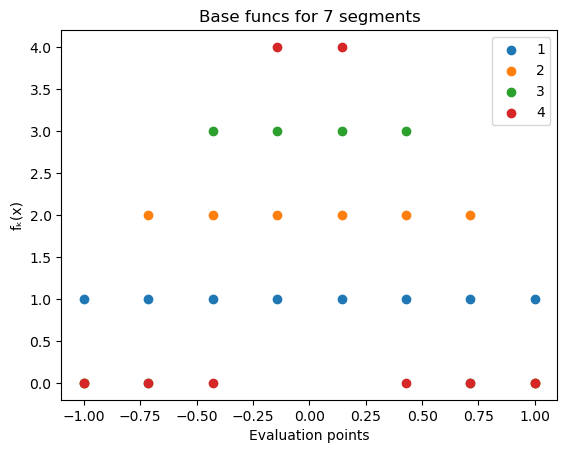

In [4]:
function make_base_funcs_tuple(n::Integer; atol::Real = 1e-12)
    # our amplitude base functions are a list of functions where the first function returns
    # 1 for all grid points, the second function returns 1 for all but the first & last points...
    @assert n ≥ 1 "n must be at least 1"
    m = n + 1
    # these are the same grid points that transform_argument will evaluate
    grid = [((i - 1) / (n / 2) - 1) for i in 1:m]
    fs_vec = [
        let k = k, grid = grid, m = m, atol = atol
            x -> begin
                exclude = k - 1
                lo = 1 + exclude
                hi = m - exclude
                if lo > hi
                    return 0.0
                end
                for j in lo:hi
                    if isapprox(x, grid[j]; atol = atol)
                        return 1.0
                    end
                end
                return 0.0
            end
        end for k in 1:cld(n+1, 2)
    ]
    return tuple(fs_vec...)
end

n_segment = 7
funs = make_base_funcs_tuple(n_segment)
xs = [((i - 1) / (n_segment / 2) - 1) for i in 1:n_segment + 1]
figure()
for (i, f) in enumerate(funs)
    ys = [f(x) for x in xs]
    scatter(xs, i * ys, label=i)
end

xlabel("Evaluation points")
ylabel("fₖ(x)")
title("Base funcs for $n_segment segments")
legend()
show()

In [5]:
const nseg = 20
buf_opt = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_allδ), Val(SS.mask_allδ));
buf_plot = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_full), Val(SS.mask_full));

amp_funcs = make_base_funcs_tuple(nseg);
const nlmodel = Seq.Objective(SL.pmask_full,
    ((:dis2, 0), (:disδ2, 0), (:area, 0),
        (:areaδ, 0), (:τ, 0)),
    objfunc, modes, buf_opt,
    freq=Seq.FreqSpec(false, sym=true),    # turn off frequency modulation
    amp=Seq.AmpSpec(cb=amp_funcs, sym=true));

In [6]:
# Set bounds for optimizer
pitime_to_Ω(time) = π / (2 * time)
# this isn't a direct limit on rabi frequency though, just amplitude of each base function
Ωmax = pitime_to_Ω(8)
τmin = 3
τmax = 20
ωmin = 2π * sysparams.modes.radial1[2]
ωmax = 2π * sysparams.modes.radial1[6]

const nargs = Seq.nparams(nlmodel)
const tracker = Opts.NLVarTracker(nargs)
for Ω in nlmodel.param.Ωs
    # set the rabi frequency bound on all amplitude base function
    Opts.set_bound!(tracker, Ω, 0, Ωmax)
end
println("Ωmax is $Ωmax")

Opts.set_bound!(tracker, nlmodel.param.τ, τmin, τmax)
println("Total gate time is between $(τmin * nseg) and $(τmax * nseg) us")

for ω in nlmodel.param.ωs
    Opts.set_bound!(tracker, ω, ωmin, ωmax)
end

opt = NLopt.Opt(:LD_LBFGS, nargs)
NLopt.min_objective!(opt, nlmodel)
NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))
NLopt.maxtime!(opt, 10)

Ωmax is 0.19634954084936207
Total gate time is between 60 and 400 us


In [7]:
best_obj = Inf
best_params = nothing
threshold = -Inf  # not setting a threshold

@time for i in 1:200
    global best_obj, best_params
    initial_params = Opts.init_vars!(tracker)
    obj, params, ret = @time NLopt.optimize(opt, initial_params)
    if getfield(NLopt, ret) < 0
        continue
    end
    if obj < best_obj
        best_obj = obj
        area = nlmodel(Val((:area, 0)), params)
        best_status = (
            obj = obj,
            dis = nlmodel(Val((:dis2, 0)), params),
            disδ = nlmodel(Val((:disδ2, 0)), params),
            area = area,
            areaε = abs(area) - π / 2,
            areaδ = nlmodel(Val((:areaδ, 0)), params),
            total_t = nlmodel(Val((:τ, 0)), params),
            Ωmax = params[nlmodel.param.Ωs[1]],
        )
        println(best_status)
        best_params = params
    end
    if best_obj < threshold
        break
    end
end

  0.009560 seconds (463 allocations: 114.391 KiB)
  0.007998 seconds (340 allocations: 83.984 KiB)
  0.001117 seconds (19 allocations: 3.734 KiB)
(obj = 246.74011002723395, dis = 0.0, disδ = 0.0, area = 0.0, areaε = -1.5707963267948966, areaδ = 0.0, total_t = 63.68903863779937, Ωmax = 0.0)
  0.003492 seconds (134 allocations: 32.484 KiB)
  0.005753 seconds (244 allocations: 59.984 KiB)
  0.003978 seconds (189 allocations: 46.234 KiB)
  0.005035 seconds (209 allocations: 51.234 KiB)
(obj = 0.07707533692394948, dis = 3.512007086444953e-5, disδ = 7.689257037102253, area = 1.5705509707726382, areaε = -0.0002453560222583917, areaδ = -10.70626376864649, total_t = 389.57800762261763, Ωmax = 0.00014343215265475584)
  0.008023 seconds (404 allocations: 99.984 KiB)
  0.005744 seconds (276 allocations: 67.984 KiB)
  0.009585 seconds (428 allocations: 105.984 KiB)
  0.005343 seconds (237 allocations: 58.234 KiB)
  0.003622 seconds (145 allocations: 35.234 KiB)
(obj = 0.05646834130845765, dis = 0.0

The max Ωs corresponds to a carrier pi time of 2.976094178647094 us


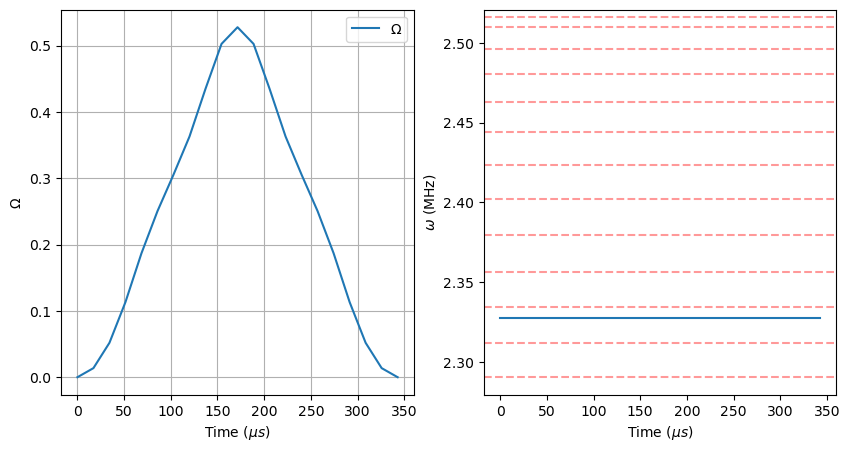

In [8]:
opt_raw_params = Seq.RawParams(nlmodel, best_params)
kern = SL.Kernel(buf_plot, Val(SL.pmask_full));

fig, axes = subplots(1, 2, figsize=(10, 5))  # n vertical subplots

ts, Ωs = Seq.get_Ωs(opt_raw_params)
axes[1].plot(ts, Ωs, label="Ω")
max_carrier_pi_time = π/maximum(Ωs)/2
println("The max Ωs corresponds to a carrier pi time of $max_carrier_pi_time us")
axes[1].set_xlabel(raw"Time ($\mu s$)")
axes[1].set_ylabel(raw"$\Omega$")
axes[1].grid(true)
axes[1].legend()

ts, ωs = Seq.get_ωs(opt_raw_params)
axes[2].plot(ts, ωs ./ 2π)
axes[2].set_xlabel(raw"Time ($\mu s$)")
axes[2].set_ylabel(raw"$\omega$ (MHz)")
for m in sysparams.modes.radial1
    axes[2].axhline(m, ls="--", color="red", alpha=0.4)
end

In [9]:
total_gate_time = best_params[nlmodel.param.τ] * nseg
total_dis = Seq.total_dis(kern, opt_raw_params, modes)
total_cumdis = Seq.total_cumdis(kern, opt_raw_params, modes)
total_disδ = Seq.total_disδ(kern, opt_raw_params, modes)
enclosed_area = Seq.total_area(kern, opt_raw_params, modes)
total_areaδ = Seq.total_areaδ(kern, opt_raw_params, modes)

println("Total gate time: $total_gate_time")
println("Total displacement: $total_dis")
println("cumulative displacement: $total_cumdis")
println("Gradient of displacement w.r.t. detuning (disδ): $total_disδ")
println("Enclosed area (area): $enclosed_area")
println("Gradient of enclosed area w.r.t. detuning (areaδ): $total_areaδ")

metadata = Dict(
    "total_gate_time" => total_gate_time,
    "total_displacement" => total_dis,
    "total_cumulative_displacement" => total_cumdis,
    "gradient_displacement_detuning" => total_disδ,
    "enclosed_area" => enclosed_area,
    "gradient_area_detuning" => total_areaδ,
    "max_carrier_pi_time" => max_carrier_pi_time,
)
metadata_str = JSON.json(metadata);

Total gate time: 343.00280656973734
Total displacement: 2.3181498266659055e-6
cumulative displacement: 0.32082527698937596
Gradient of displacement w.r.t. detuning (disδ): 0.3208252769193093
Enclosed area (area): -1.5707860688791473
Gradient of enclosed area w.r.t. detuning (areaδ): -9.351043755950007


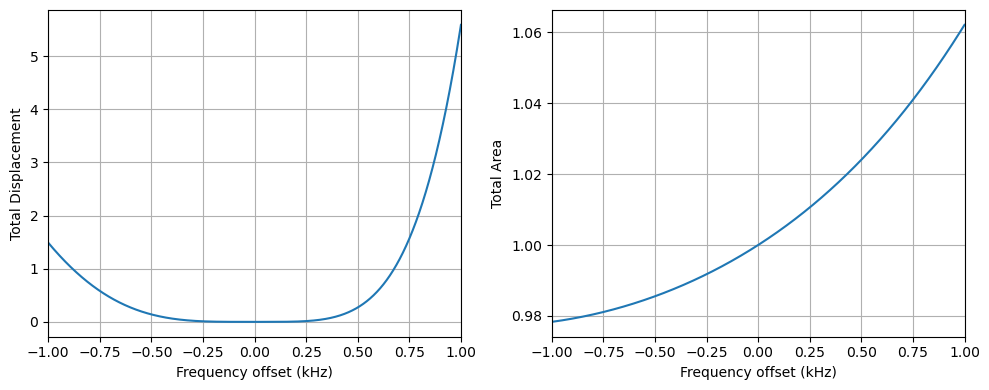

In [10]:
fig, axes = subplots(1, 2, figsize=(10, 4))  # n vertical subplots

plot_δs = range(-1, 1, 10001); # kHz
axes[1].plot(plot_δs, [Seq.total_dis(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) for δ in plot_δs])
axes[1].set_xlim([-1, 1])
# ylim([0, 100])
axes[1].set_xlabel("Frequency offset (kHz)")
axes[1].set_ylabel("Total Displacement")
axes[1].grid(true)

area0 = Seq.total_area(kern, opt_raw_params, modes)
axes[2].plot(plot_δs, [Seq.total_area(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) / area0 for δ in plot_δs])
axes[2].set_xlim([-1, 1])
axes[2].set_xlabel("Frequency offset (kHz)")
axes[2].set_ylabel("Total Area")
axes[2].grid(true)
tight_layout()

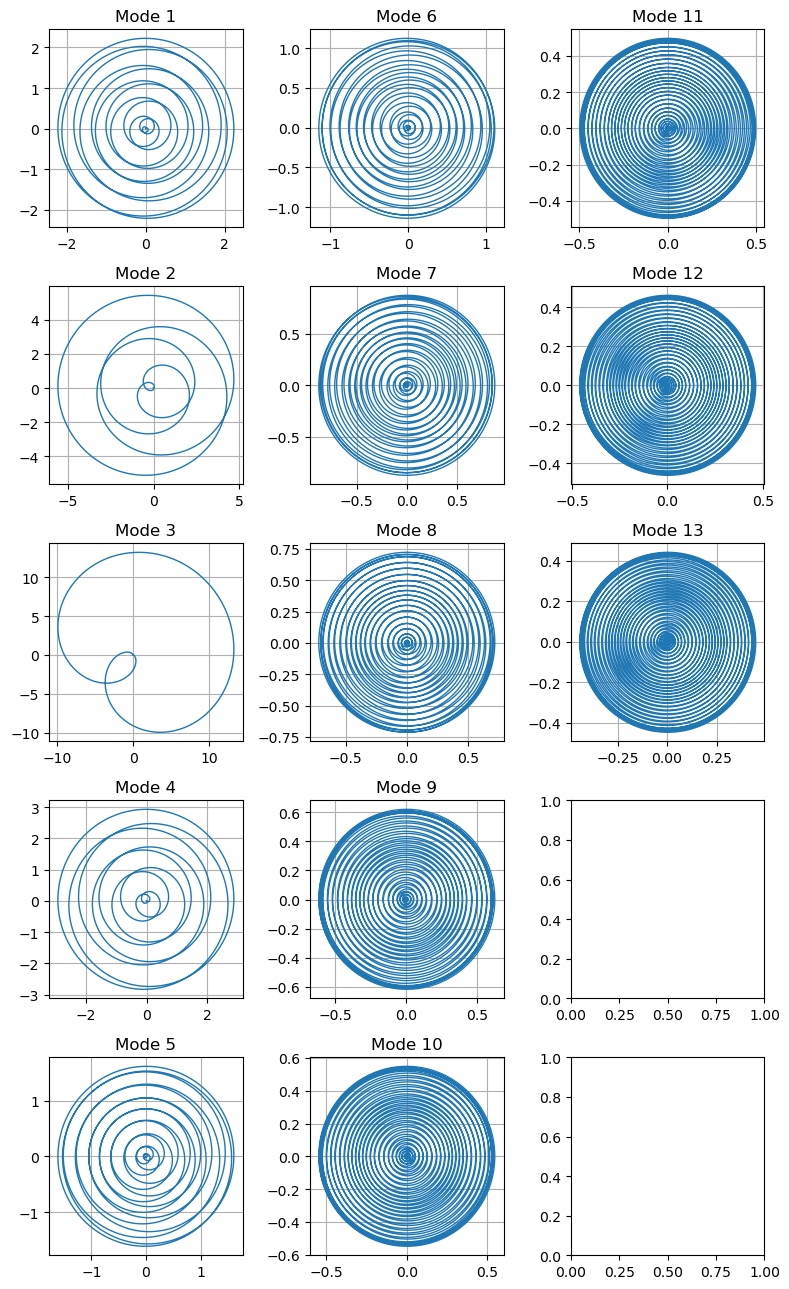

In [11]:
n = length(modes.modes)  # total number of modes
fig, axes = subplots(cld(n, 3), 3, figsize=(8, n))  # n vertical subplots

for i in 1:n
    _, xs, ys = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[i][1])
    ax = axes[i]
    ax.plot(xs, ys, lw=1)
    ax.set_title("Mode $i")
    ax.grid(true)
end

tight_layout()
show()

In [12]:
_ion1 = ion1 - (nions + 1) ÷ 2
_ion2 = ion2 - (nions + 1) ÷ 2
solution_set = GoldGates.GateSolutionSet(params=sysparams,
    XX=Dict("$_ion2,$_ion1" => GoldGates.XXSolution(opt_raw_params, enclosed_area, metadata=metadata_str)))
open("../out/20251120_am_13.json", "w") do io
    write(io, solution_set, format=:json)
end